# Enable Agent Tutorial Part 1: ML 모델 학습

## 개요

이 노트북에서는 Iris 데이터셋으로 Random Forest 분류 모델을 학습하고 저장한다. 학습된 모델은 Part 2에서 Enable Agent로 변환된다.

## 학습 내용

- Iris 데이터셋 로드 및 탐색
- Random Forest 모델 학습
- 모델 성능 평가
- 모델 및 메타데이터 저장

---
## 1. 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'DejaVu Sans'
print("라이브러리 임포트 완료")

라이브러리 임포트 완료


---
## 2. Iris 데이터셋 로드 및 탐색

Iris 데이터셋은 3가지 붓꽃 품종(Setosa, Versicolor, Virginica)을 4가지 특성(꽃받침 길이/너비, 꽃잎 길이/너비)으로 분류하는 고전적인 머신러닝 데이터셋이다.

In [2]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print("=== Iris 데이터셋 정보 ===")
print(f"특성 수: {X.shape[1]}")
print(f"샘플 수: {X.shape[0]}")
print(f"클래스: {target_names}")
print(f"\n특성명:")
for i, name in enumerate(feature_names):
    print(f"  {i}: {name}")

=== Iris 데이터셋 정보 ===
특성 수: 4
샘플 수: 150
클래스: ['setosa' 'versicolor' 'virginica']

특성명:
  0: sepal length (cm)
  1: sepal width (cm)
  2: petal length (cm)
  3: petal width (cm)


In [3]:
df = pd.DataFrame(X, columns=feature_names)
df['species'] = [target_names[i] for i in y]

print("=== 데이터 미리보기 ===")
display(df.head(10))

print("\n=== 기술 통계 ===")
display(df.describe())

=== 데이터 미리보기 ===


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa



=== 기술 통계 ===


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


---
## 3. 데이터 시각화

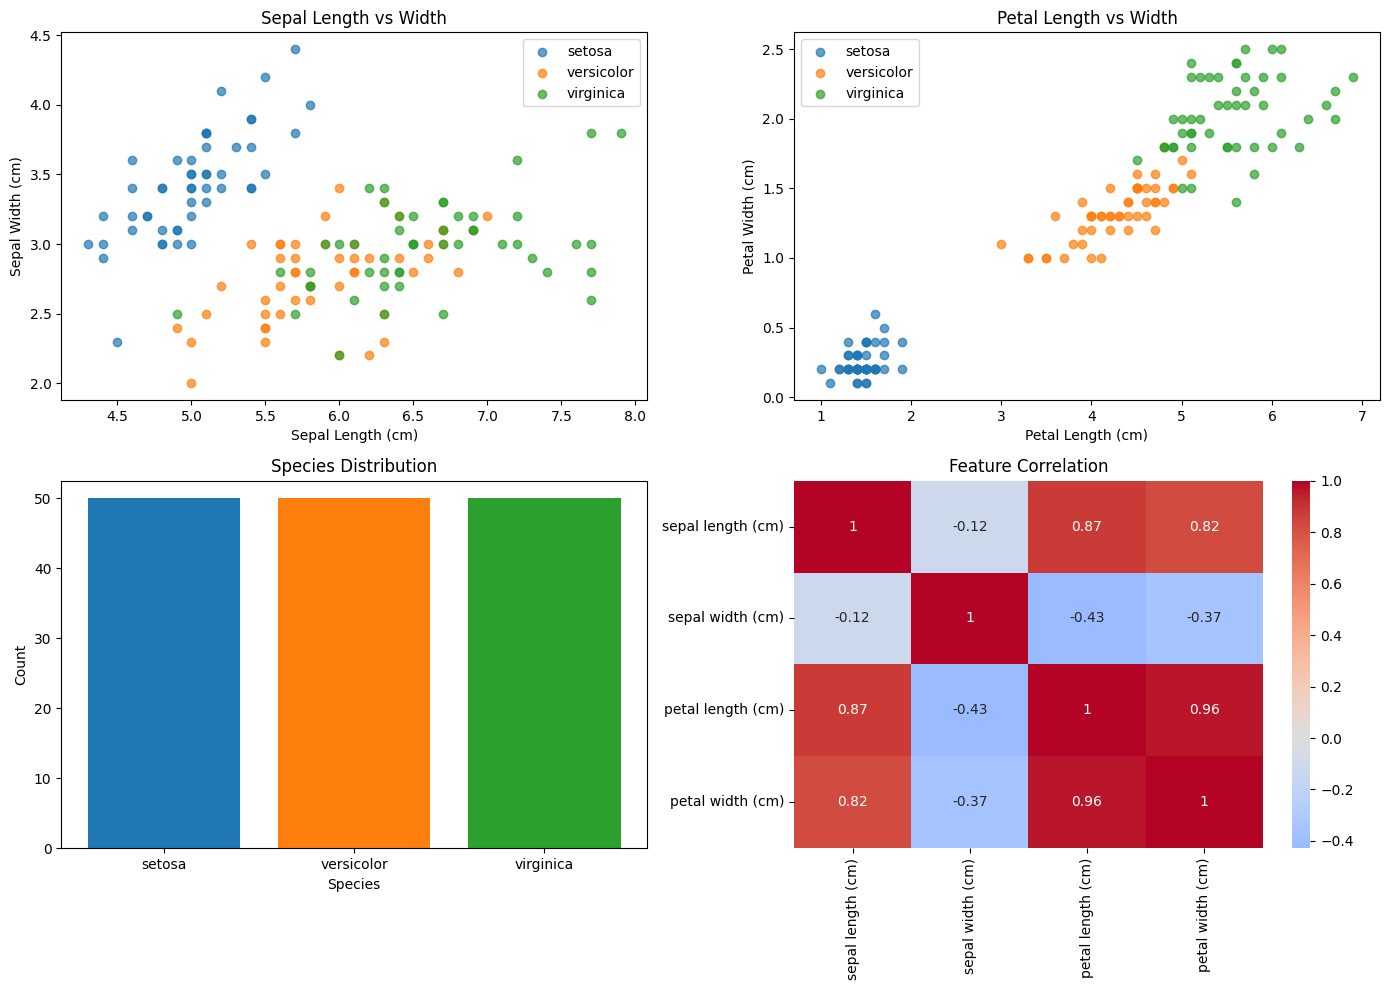

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 꽃받침 길이 vs 너비
ax1 = axes[0, 0]
for species in target_names:
    subset = df[df['species'] == species]
    ax1.scatter(subset['sepal length (cm)'], subset['sepal width (cm)'], label=species, alpha=0.7)
ax1.set_xlabel('Sepal Length (cm)')
ax1.set_ylabel('Sepal Width (cm)')
ax1.set_title('Sepal Length vs Width')
ax1.legend()

# 꽃잎 길이 vs 너비
ax2 = axes[0, 1]
for species in target_names:
    subset = df[df['species'] == species]
    ax2.scatter(subset['petal length (cm)'], subset['petal width (cm)'], label=species, alpha=0.7)
ax2.set_xlabel('Petal Length (cm)')
ax2.set_ylabel('Petal Width (cm)')
ax2.set_title('Petal Length vs Width')
ax2.legend()

# 품종별 분포
ax3 = axes[1, 0]
species_counts = df['species'].value_counts()
ax3.bar(species_counts.index, species_counts.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax3.set_xlabel('Species')
ax3.set_ylabel('Count')
ax3.set_title('Species Distribution')

# 상관관계 히트맵
ax4 = axes[1, 1]
corr_matrix = df.drop('species', axis=1).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax4)
ax4.set_title('Feature Correlation')

plt.tight_layout()
plt.show()

---
## 4. 모델 학습

Random Forest는 여러 개의 결정 트리를 앙상블하여 분류하는 알고리즘이다. 과적합에 강하고 특성 중요도를 제공한다.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"학습 세트: {len(X_train)}개")
print(f"테스트 세트: {len(X_test)}개")

학습 세트: 120개
테스트 세트: 30개


In [6]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)
print("모델 학습 완료")

모델 학습 완료


---
## 5. 모델 평가

In [7]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"=== 모델 성능 ===")
print(f"정확도: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\n분류 보고서:")
print(classification_report(y_test, y_pred, target_names=target_names))

=== 모델 성능 ===
정확도: 0.9333 (93.33%)

분류 보고서:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



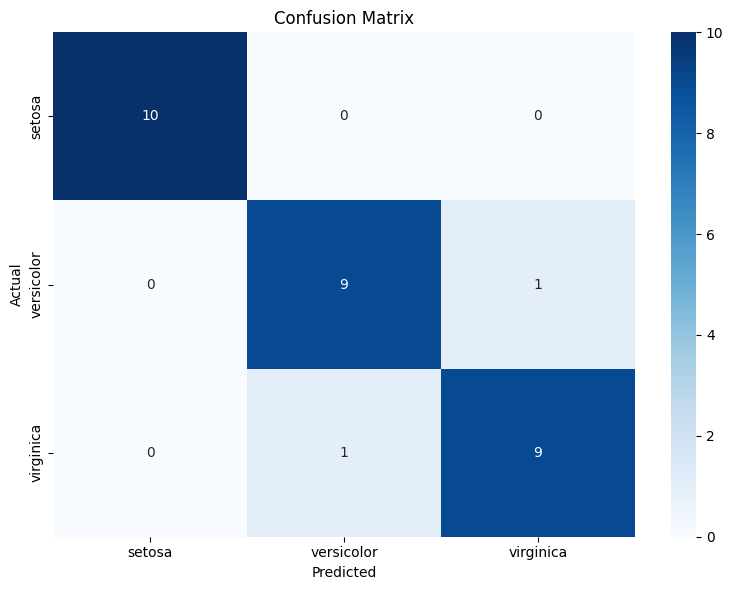

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

=== 특성 중요도 ===


,feature,importance
3,petal width (cm),0.438141
2,petal length (cm),0.431641
0,sepal length (cm),0.115972
1,sepal width (cm),0.014246


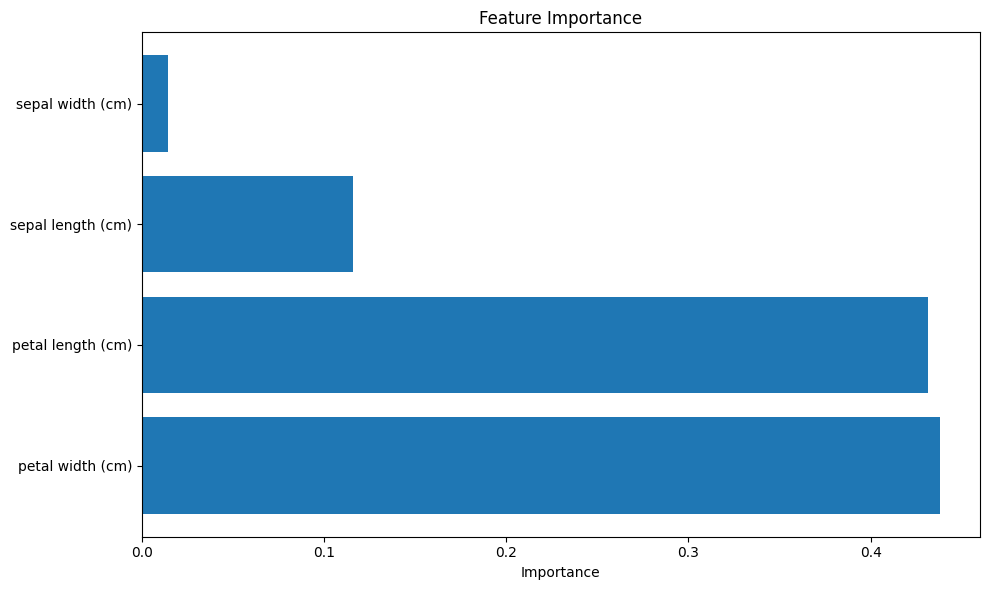

In [9]:
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== 특성 중요도 ===")
display(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

---
## 6. 모델 저장

학습된 모델과 메타데이터를 파일로 저장한다. 이 파일들은 Part 2에서 Enable Agent로 변환할 때 사용된다.

In [10]:
os.makedirs('models', exist_ok=True)
os.makedirs('skills', exist_ok=True)
os.makedirs('context_store', exist_ok=True)

model_path = 'models/iris_classifier.pkl'
joblib.dump(model, model_path)
print(f"모델 저장 완료: {model_path}")

metadata = {
    "model_name": "Iris Random Forest Classifier",
    "model_type": "RandomForestClassifier",
    "accuracy": float(accuracy),
    "feature_names": feature_names,
    "target_names": target_names.tolist(),
    "n_features": len(feature_names),
    "n_classes": len(target_names),
    "training_samples": len(X_train),
    "test_samples": len(X_test),
    "hyperparameters": {
        "n_estimators": 100,
        "max_depth": 5,
        "random_state": 42
    },
    "feature_importance": dict(zip(feature_names, model.feature_importances_.tolist()))
}

metadata_path = 'models/iris_classifier_metadata.json'
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"메타데이터 저장 완료: {metadata_path}")
print("\n저장된 메타데이터:")
print(json.dumps(metadata, indent=2, ensure_ascii=False))

모델 저장 완료: models/iris_classifier.pkl
메타데이터 저장 완료: models/iris_classifier_metadata.json

저장된 메타데이터:
{
  "model_name": "Iris Random Forest Classifier",
  "model_type": "RandomForestClassifier",
  "accuracy": 0.9333333333333333,
  "feature_names": [
    "sepal length (cm)",
    "sepal width (cm)",
    "petal length (cm)",
    "petal width (cm)"
  ],
  "target_names": [
    "setosa",
    "versicolor",
    "virginica"
  ],
  "n_features": 4,
  "n_classes": 3,
  "training_samples": 120,
  "test_samples": 30,
  "hyperparameters": {
    "n_estimators": 100,
    "max_depth": 5,
    "random_state": 42
  },
  "feature_importance": {
    "sepal length (cm)": 0.11597202747414688,
    "sepal width (cm)": 0.014245784901421163,
    "petal length (cm)": 0.43164136172170253,
    "petal width (cm)": 0.4381408259027294
  }
}


---
## 7. 저장된 모델 테스트

저장된 모델을 다시 로드하여 정상 작동하는지 확인한다.

In [11]:
loaded_model = joblib.load(model_path)

test_sample = X_test[0:1]
prediction = loaded_model.predict(test_sample)[0]
probabilities = loaded_model.predict_proba(test_sample)[0]

print("=== 저장된 모델 테스트 ===")
print(f"입력 특성: {test_sample[0]}")
print(f"예측 품종: {target_names[prediction]}")
print(f"실제 품종: {target_names[y_test[0]]}")
print(f"\n각 품종별 확률:")
for i, prob in enumerate(probabilities):
    print(f"  {target_names[i]}: {prob:.4f} ({prob*100:.2f}%)")

print("\n모델이 정상적으로 작동한다.")

=== 저장된 모델 테스트 ===
입력 특성: [4.4 3.  1.3 0.2]
예측 품종: setosa
실제 품종: setosa

각 품종별 확률:
  setosa: 1.0000 (100.00%)
  versicolor: 0.0000 (0.00%)
  virginica: 0.0000 (0.00%)

모델이 정상적으로 작동한다.
